# Traffic Sign Classifier With Pytorch

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torchvision


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler
from torchvision import utils
import torchvision.transforms as T


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
%matplotlib inline


I used a pickle version of the German Traffic sign dataset where the images are resized to 32*32. <br />
This allows faster loading of data, thus also speed up training

In [0]:
import pickle

In [0]:
# Newest version of PIL
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one

In [5]:
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [228]:

# Load data
root = "/content/drive/My Drive/Colab_Notebooks/Traffic_sign_classifier/Dataset/"
training_file = root + "train.p"
testing_file = root + "test.p"


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

    
print(train.keys())
X, y = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
coordinates, sizes = train['coords'], train['sizes']

dict_keys(['coords', 'sizes', 'labels', 'features'])


## Data Exploaration

In [229]:
# Basic data summary.

n = len(X)
n_test = len(X_test)
image_shape = X[10].shape
n_classes = len(set(y))
img_size =  image_shape[0]

print("Number of training examples: ", n)
print("Number of testing examples: ", n_test)
print("Image data shape: ", image_shape)
print("Number of classes: ", n_classes)



Number of training examples:  39209
Number of testing examples:  12630
Image data shape:  (32, 32, 3)
Number of classes:  43


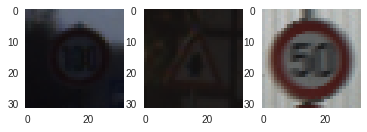

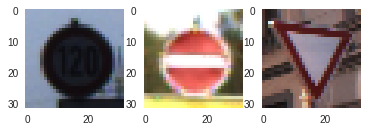

In [230]:
# Plot a couple of images

for i in range(3):
  idx = np.random.randint(0, n)
  plt.subplot(1, 3, i+1)
  plt.imshow(X[idx])

plt.figure()

for i in range(3):
  idx = np.random.randint(0, n_test)
  plt.subplot(1, 3, i+1)
  plt.imshow(X_test[idx])
  

[]

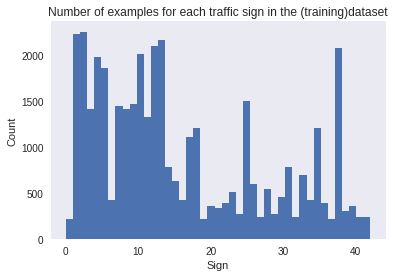

In [231]:
# Plot a histogram to visualize classes distribution

plt.hist(y, bins=n_classes)
plt.title('Number of examples for each traffic sign in the (training)dataset')
plt.xlabel('Sign')
plt.ylabel('Count')
plt.plot()

The classes are imbalanced. A solution would be data augmentation

## Dataset Class

In [0]:
class TrafficSignDataset(Dataset):
  
  def __init__(self, X, y, transform=None):
    """
      X : Images data
      y : labels of data
      transforms: callable function for preprocessing
    """
    self.x = X
    self.y = y
    self.transform = transform
    
  def __len__(self):
    return len(self.x)
  
  def __getitem__(self, idx):
    
    if self.transform:
            sample = self.transform(self.x[idx])
    return sample, self.y[idx]
  

In [0]:

def plt_sample_batched(img, title=None):
    
    plt.figure()
    
    # ref : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    # From tensor to image
    img = img.numpy().transpose((1, 2, 0))    
       
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)        
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Load Data and Split in Train/val and Data Augmentation

In [0]:


mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

# data augmentation
train_transform = T.Compose([ 
        T.ToPILImage(),
        T.RandomHorizontalFlip(),        
        T.RandomCrop(size=img_size, padding=4),                
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ])

val_transform = T.Compose([ 
        T.ToPILImage(),
        T.RandomHorizontalFlip(),        
        T.RandomCrop(size=img_size, padding=4),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ])

test_transform = T.Compose([T.ToPILImage(),
                            T.ToTensor(),
                            T.Normalize(mean=mean, std=std)
                           ])


dataset_train = TrafficSignDataset(X, y, train_transform)
dataset_test = TrafficSignDataset(X_test, y_test, test_transform)


# I chose split 80/20 for train/val

train_split = 0.8
split = int(np.floor(train_split*n))
indices = list(range(n))


# shuffle
np.random.shuffle(indices)
train_indices, val_indices = indices[:split], indices[split:]



loader_train = DataLoader(dataset_train, batch_size=64, 
                              sampler=sampler.SubsetRandomSampler(train_indices))                          

loader_val = DataLoader(dataset_train, batch_size=64, 
                              sampler=sampler.SubsetRandomSampler(val_indices))

loader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)



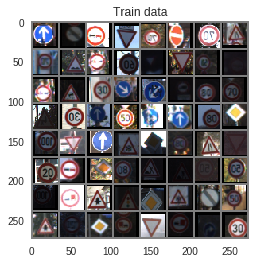

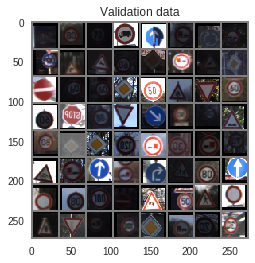

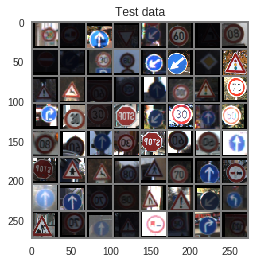

In [235]:
# show a batch of data

train_iter = iter(loader_train)
val_iter = iter(loader_train)
test_iter = iter(loader_train)

train_sample, train_labels = train_iter.next()
val_sample, val_labels = val_iter.next()
test_sample, test_labels = test_iter.next()



# Make a grid from batch
grid_train = utils.make_grid(train_sample)
plt_sample_batched(grid_train, title='Train data')

grid_val = utils.make_grid(val_sample)
plt_sample_batched(grid_val, title='Validation data')


grid_test = utils.make_grid(test_sample)
plt_sample_batched(grid_test, title='Test data')

In [236]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 5000

print('using device:', device)

using device: cuda


### Initialization

In [0]:
# Helper function

def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

def ones_weight(shape):
    return torch.ones(shape, device=device, dtype=dtype, requires_grad=True)
  


### Accuracy Function

In [0]:
def check_accuracy_part34(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

### Training Function

In [0]:
import torch.nn.functional as F  # useful stateless functions

def train_part34(model, optimizer, epochs=1):
    """    
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)            
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                 print('Iteration %d, loss = %.4f' % (t, loss.item()))
                 check_accuracy_part34(loader_val, model)
                 print()

## Architecture

Convolutional network with twelve learnable layers, including six convolutional layers.
Batch normalization (to accelerate training and small regularization effect) is used after each convolution.
ReLU is used for non-linearities.
I started with a small network (conv-relu-pool x2).
Following the same architecture would reduce the size of the image a lot. So I stacked the two conv layers before each pooling layer.
For the size of the feature maps, I used a simple 32, 64, 128 scheme.
I use Global Average pooling to reduce the feature map to (1,1, 128), then one fully connected layer.
Global average pooling perfoms slightly better than Global Max pooling

 [[conv-bn-relu]x2-pool]x3 -> GAP -> affine -> [cross entropy loss]

In [0]:

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
  
class Flatten(nn.Module):
  def forward(self, x):
      return flatten(x)

class ConvBlock(nn.Module):
  def __init__(self, feature_maps, kernel_size):
    
    super(ConvBlock, self).__init__()
    
    self.conv_1 = nn.Conv2d(feature_maps[0], feature_maps[1],
                            kernel_size=kernel_size, padding=1)
    self.batchnorm_1 = nn.BatchNorm2d(feature_maps[1])
    
    self.conv_2 = nn.Conv2d(feature_maps[1], feature_maps[1],
                            kernel_size=kernel_size, padding=1)
    self.batchnorm_2 = nn.BatchNorm2d(feature_maps[1])
    
        
    # init weights
    nn.init.kaiming_normal_(self.conv_1.weight)
    nn.init.kaiming_normal_(self.conv_2.weight)    
    
  def forward(self, x):
    
    scores = None
    x = F.relu(self.batchnorm_1(self.conv_1(x)))
    scores = F.relu(self.batchnorm_2(self.conv_2(x)))
    
    return scores
  


# Weight initialization
# Ref: http://pytorch.org/docs/stable/nn.html#torch.nn.Module.apply
def init_weights(m):    
    if type(m) == nn.Linear or type(m) == nn.BatchNorm2d:
        random_weight(m.weight.size())
        zero_weight(m.bias.size())       


In [0]:
ConvBlock_1 = ConvBlock([3, 32], 3)
ConvBlock_2 = ConvBlock([32, 64], 3)
ConvBlock_3 = ConvBlock([64, 128], 3)

model = nn.Sequential(
          ConvBlock_1,              
          nn.MaxPool2d(2),          
          ConvBlock_2,          
          nn.MaxPool2d(2),          
          ConvBlock_3,    
          nn.MaxPool2d(2),          
          nn.AvgPool2d(4),
          Flatten(),
          nn.Linear(128, n_classes)
)

## Training

In [242]:
model.apply(init_weights)


Sequential(
  (0): ConvBlock(
    (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ConvBlock(
    (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): ConvBlock(
    (conv_1): Conv2d(64, 128, kernel_size=(3, 3

In [243]:
learning_rate = 1e-3
print_every = 10000


optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_part34(model, optimizer, epochs=10)


print('training accuracy')
print(check_accuracy_part34(loader_train, model))

print('validation accuracy')
print(check_accuracy_part34(loader_val, model))


Iteration 0, loss = 3.7409
Got 72 / 7842 correct (0.92)

Iteration 0, loss = 0.8722
Got 5437 / 7842 correct (69.33)

Iteration 0, loss = 0.2674
Got 6368 / 7842 correct (81.20)

Iteration 0, loss = 0.1284
Got 7453 / 7842 correct (95.04)

Iteration 0, loss = 0.1068
Got 7623 / 7842 correct (97.21)

Iteration 0, loss = 0.0883
Got 7497 / 7842 correct (95.60)

Iteration 0, loss = 0.0327
Got 7667 / 7842 correct (97.77)

Iteration 0, loss = 0.0241
Got 7705 / 7842 correct (98.25)

Iteration 0, loss = 0.0435
Got 7687 / 7842 correct (98.02)

Iteration 0, loss = 0.0486
Got 7720 / 7842 correct (98.44)

training accuracy
Got 30950 / 31367 correct (98.67)
0.9867057735837026
validation accuracy
Got 7693 / 7842 correct (98.10)
0.9809997449630197


## Test on random images from the web

In [0]:

new_images = root + "new_images/"
names = ["1x.png", "2x.png", "3x.png", "4x.png", "5x.png", "6x.png", "7x.png", "8x.png"]

labels_var = [11, 1, 12, 38, 34, 18, 25, 3]
  

In [0]:

class WebImagesDataset(Dataset):
  
  def __init__(self, root_dir, names, y, transform=None):
    """
      X : Images data
      y : labels of data
      transforms: callable function for preprocessing
    """
    self.root_dir = root_dir
    self.names = names
    self.y = y
    self.transform = transform
    
  def __len__(self):
    return len(self.names)
  
  def __getitem__(self, idx):  
    
    img_name = os.path.join(self.root_dir, self.names[idx])
    image = Image.open(img_name).convert('RGB')
    
    if self.transform:
            sample = self.transform(image)
    return sample, self.y[idx]

In [0]:
transform = T.Compose([T.ToTensor(),
                      T.Normalize(mean=mean, std=std)
                      ])

Images = WebImagesDataset(new_images, names, labels_var, transform)
loader = DataLoader(Images, batch_size=8)               



accuracy : 100.0


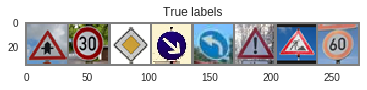

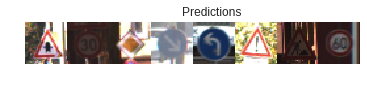

In [193]:
with torch.no_grad():
  model.eval()
  for x, y in loader:
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=torch.long)
      scores = model(x)     
      _, preds = scores.max(1)    
      num_correct = (preds == y).sum()
      num_samples = preds.size(0)
      acc = float(num_correct) / num_samples
           
      
print('accuracy :', acc*100)



batch = iter(loader)
sample, _ = batch.next()
grid = utils.make_grid(sample)
plt_sample_batched(grid, title='True labels')

fig, axs = plt.subplots(1,8)
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i, prediction in enumerate(preds):
  idx = np.argwhere(train['labels'] == prediction)[0][100]    
  x_pred = X[idx]
  img = std * x_pred + mean
  img = np.clip(img, 0, 1)
  axs[i].axis('off')
  axs[i].imshow(x_pred)
  axs[4].set_title("Predictions ")
    

## Accuracy on the Test set

In [244]:
print(check_accuracy_part34(loader_test, model))

Got 11781 / 12630 correct (93.28)
0.9327790973871734


## Improvements
A couple of things can be done to improve the models, especialy the test accuracy. <br />
- Spatial Transformer Networks: An STN block will allow the model to be invariant to rotation and scale.
- Scheduler learning rate

